In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install python-dotenv

In [ ]:
from dotenv import load_dotenv
import os

# สมมติไฟล์ .env อยู่ใน root ของ Colab
load_dotenv('.env')

# ตรวจสอบว่าโหลดค่าได้หรือไม่
print(os.getenv("PINECONE_API_KEY"))
print(os.getenv("TYPHOON_API_KEY"))


None
None


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [13]:
import os
import json
import re
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any, Optional, Tuple
from pathlib import Path


# API and ML libraries
import openai
from dotenv import load_dotenv
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone

# Load environment variables
load_dotenv('/content/env')

print("Libraries imported successfully!")

Libraries imported successfully!


In [14]:
CONFIG = {
    'PINECONE_API_KEY': os.getenv("PINECONE_API_KEY"),
    'PINECONE_INDEX_NAME': os.getenv("PINECONE_INDEX_NAME", "thai-civil-code"),
    'TYPHOON_API_KEY': os.getenv("TYPHOON_API_KEY"),
    'TYPHOON_BASE_URL': "https://api.opentyphoon.ai/v1",
    'TYPHOON_MODEL': "typhoon-v2.1-12b-instruct",
    'DEVICE': "cuda" if torch.cuda.is_available() else "cpu",
    'MAX_SAMPLES': 20,  # Number of samples to evaluate
    'RETRIEVAL_K': 10,   # Number of documents to retrieve
}

# Verify required API keys
required_keys = ['PINECONE_API_KEY', 'TYPHOON_API_KEY']
for key in required_keys:
    assert CONFIG[key], f"Missing {key} in environment variables"

print("Configuration loaded:")
for key, value in CONFIG.items():
    if 'API_KEY' in key:
        print(f"  {key}: {'✓ Set' if value else '✗ Missing'}")
    else:
        print(f"  {key}: {value}")

Configuration loaded:
  PINECONE_API_KEY: ✓ Set
  PINECONE_INDEX_NAME: thai-civil-code-bge-m3
  TYPHOON_API_KEY: ✓ Set
  TYPHOON_BASE_URL: https://api.opentyphoon.ai/v1
  TYPHOON_MODEL: typhoon-v2.1-12b-instruct
  DEVICE: cuda
  MAX_SAMPLES: 20
  RETRIEVAL_K: 10


In [15]:
# Verify required API keys
required_keys = ['PINECONE_API_KEY', 'TYPHOON_API_KEY']
for key in required_keys:
    assert CONFIG[key], f"Missing {key} in environment variables"

print("Configuration loaded:")
for key, value in CONFIG.items():
    if 'API_KEY' in key:
        print(f"  {key}: {'✓ Set' if value else '✗ Missing'}")
    else:
        print(f"  {key}: {value}")

Configuration loaded:
  PINECONE_API_KEY: ✓ Set
  PINECONE_INDEX_NAME: thai-civil-code-bge-m3
  TYPHOON_API_KEY: ✓ Set
  TYPHOON_BASE_URL: https://api.opentyphoon.ai/v1
  TYPHOON_MODEL: typhoon-v2.1-12b-instruct
  DEVICE: cuda
  MAX_SAMPLES: 20
  RETRIEVAL_K: 10


In [16]:
def extract_sections_from_text(text: str) -> List[str]:
    """
    Extract Thai legal section numbers from text with robust pattern matching.

    Args:
        text: Input text containing legal references

    Returns:
        List of extracted section numbers
    """
    if not text or pd.isna(text):
        return []

    # Convert Thai digits to Arabic numerals
    thai_to_arabic = str.maketrans("๐๑๒๓๔๕๖๗๘๙", "0123456789")
    normalized_text = str(text).translate(thai_to_arabic)

    # Patterns for section extraction (ordered by specificity)
    section_patterns = [
        r"(?:มาตรา|Section)\s*([0-9]+(?:/[0-9]+)?(?:\([0-9]+\))?)",  # Full format with subsections
        r"(?:มาตรา|Section)\s*([0-9]+(?:/[0-9]+)?)",                # With slash notation
        r"\b([0-9]{2,}(?:/[0-9]+)?)\b"                              # Standalone numbers (fallback)
    ]

    found_sections = []
    for pattern in section_patterns:
        matches = re.findall(pattern, normalized_text)
        found_sections.extend(matches)

        # If we found sections with explicit keywords, don't use fallback
        if matches and 'มาตรา|Section' in pattern:
            break

    # Remove duplicates while preserving order
    unique_sections = []
    seen = set()
    for section in found_sections:
        if section not in seen:
            seen.add(section)
            unique_sections.append(section)

    return unique_sections

def parse_sections_field(field_value) -> List[str]:
    """Parse sections field which might be JSON string, list, or plain text."""
    if pd.isna(field_value) or field_value == '':
        return []

    # Handle list input
    if isinstance(field_value, list):
        return [str(s).strip() for s in field_value if s]

    # Try JSON parsing first
    try:
        parsed = json.loads(str(field_value))
        if isinstance(parsed, list):
            return [str(s).strip() for s in parsed if s]
    except (json.JSONDecodeError, ValueError, TypeError):
        pass

    # Extract from text using regex
    return extract_sections_from_text(str(field_value))

def load_and_clean_dataset(csv_path: str) -> pd.DataFrame:
    """Load and normalize the NitiBench dataset with proper preprocessing."""

    if not Path(csv_path).exists():
        raise FileNotFoundError(f"Dataset file not found: {csv_path}")

    df = pd.read_csv(csv_path)
    print(f"Raw dataset shape: {df.shape}")

    # Column mapping for standardization
    column_mapping = {
        'question': 'question_text',
        'answer': 'answer_gold',
        'relevant_laws': 'relevant_laws_gold',
        'sections_extracted': 'sections_gold',
    }

    # Apply renaming only for existing columns
    existing_mappings = {k: v for k, v in column_mapping.items() if k in df.columns}
    df = df.rename(columns=existing_mappings)
    print(f"Column mapping applied: {existing_mappings}")

    # Clean and parse sections_gold column
    if 'sections_gold' in df.columns:
        df['sections_gold'] = df['sections_gold'].apply(parse_sections_field)

        # Display sections statistics
        section_counts = df['sections_gold'].apply(len)
        print(f"\nSections statistics:")
        print(f"  Mean sections per question: {section_counts.mean():.2f}")
        print(f"  Questions with sections: {(section_counts > 0).sum()}/{len(df)}")

    # Display basic info
    print(f"\nFinal dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    return df

In [33]:
DATASET_PATH = 'nitibench_civil_only.csv'

try:
    df = load_and_clean_dataset(DATASET_PATH)
    print(f"\nDataset loaded successfully!")


except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the dataset file is in the current directory.")

Raw dataset shape: (1615, 4)
Column mapping applied: {'question': 'question_text', 'answer': 'answer_gold', 'relevant_laws': 'relevant_laws_gold', 'sections_extracted': 'sections_gold'}

Sections statistics:
  Mean sections per question: 1.27
  Questions with sections: 1609/1615

Final dataset shape: (1615, 4)
Columns: ['question_text', 'answer_gold', 'relevant_laws_gold', 'sections_gold']

Dataset loaded successfully!


In [ ]:
df.head()

,question_text,answer_gold,relevant_laws_gold,sections_gold
0,ถ้าผู้ิยู่ในปกครองได้ยินยอมในการกระทำของผู้ปกค...,การที่ผู้อยู่ในปกครองได้ยินยอมด้วยนั้นไม่ได้คุ...,"[{'law_name': 'ประมวลกฎหมายแพ่งและพาณิชย์', 's...","[1598/5, 1598]"
1,ถ้าผู้รับประกันภัยต้องคำพิพากษาให้เป็นคนล้มละล...,ผู้เอาประกันภัยจะเรียกให้หาประกันอันสมควรให้แก...,"[{'law_name': 'ประมวลกฎหมายแพ่งและพาณิชย์', 's...",[876]
2,ถ้าผู้เป็นหุ้นส่วนให้ความเป็นเจ้าของในทรัพย์สิ...,ให้บังคับตามบทบัญญัติแห่งประมวลกฎหมายแพ่งและพา...,"[{'law_name': 'ประมวลกฎหมายแพ่งและพาณิชย์', 's...",[1030]
3,ถ้ามีการรับชำระหนี้ตามสัญญา นายหน้ามีอำนาจจะรั...,รับชำระหนี้อันจะต้องชำระตามสัญญานั้น ให้สันนิษ...,"[{'law_name': 'ประมวลกฎหมายแพ่งและพาณิชย์', 's...",[849]
4,การเช่าถือสวนมีระยะเวลากี่ปี,การเช่าถือสวนมีระยะเวลาหนึ่งปี,"[{'law_name': 'ประมวลกฎหมายแพ่งและพาณิชย์', 's...",[565]


In [18]:
def setup_embeddings() -> HuggingFaceBgeEmbeddings:
    """Initialize BGE-M3 multilingual embeddings."""

    embeddings = HuggingFaceBgeEmbeddings(
        model_name="BAAI/bge-m3",
        model_kwargs={"device": CONFIG['DEVICE']},
        encode_kwargs={"normalize_embeddings": True},
        query_instruction="Represent this sentence for searching relevant passages:",
        embed_instruction="Represent this passage for retrieval:",
    )

    print(f"BGE-M3 embeddings initialized on {CONFIG['DEVICE']}")
    return embeddings

# Initialize embeddings
embeddings = setup_embeddings()

# Test embeddings with sample text
sample_text = "การเช่าที่ดินตามประมวลกฎหมายแพ่งและพาณิชย์"
sample_embedding = embeddings.embed_query(sample_text)
print(f"Sample embedding dimension: {len(sample_embedding)}")

/tmp/ipython-input-11256411.py:4: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceBgeEmbeddings(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

BGE-M3 embeddings initialized on cuda
Sample embedding dimension: 1024


In [19]:
def setup_vector_store(embeddings) -> PineconeVectorStore:
    """Initialize Pinecone vector store for retrieval."""

    pc = Pinecone(api_key=CONFIG['PINECONE_API_KEY'])

    vector_store = PineconeVectorStore(
        index_name=CONFIG['PINECONE_INDEX_NAME'],
        embedding=embeddings
    )

    print(f"Connected to Pinecone index: {CONFIG['PINECONE_INDEX_NAME']}")
    return vector_store

# Initialize vector store
vector_store = setup_vector_store(embeddings)

# Test retrieval
test_query = "สัญญาเช่าที่ดิน"
test_docs = vector_store.similarity_search(test_query, k=5)
print(f"Test retrieval returned {len(test_docs)} documents")
print(test_docs[0])

Connected to Pinecone index: thai-civil-code-bge-m3
Test retrieval returned 5 documents
page_content='ด้วยมรดกและพินัยกรรม

ลักษณะ ๔
เช่าทรัพย์

หมวด ๑
บทเบ็ดเสร็จทั่วไป

มาตรา ๕๓๗ อันว่าเช่าทรัพย์สินนี้ คือสัญญาซึ่งบุคคลคนหนึ่งเรียกว่า ผู้ให้เช่า ตกลงให้
บุคคลอีกคนหนึ่งเรียกว่า ผู้เช่า ได้ใช้หรือได้รับประโยชน์ในทรัพย์สินอย่างใดอย่างหนึ่งชั่วระยะเวลาอันมีจำกัด
และผู้เช่าตกลงจะให้ค่าเช่าเพื่อการนั้น' metadata={'source': 'output_full.md'}


In [20]:
def setup_typhoon_client():
    """Initialize OpenTyphoon API client."""

    client = openai.OpenAI(
        api_key=CONFIG['TYPHOON_API_KEY'],
        base_url=CONFIG['TYPHOON_BASE_URL']
    )

    print(f"Typhoon client initialized for model: {CONFIG['TYPHOON_MODEL']}")
    return client

# Initialize Typhoon client
typhoon_client = setup_typhoon_client()

# Test API connection
def test_typhoon_connection():
    """Test Typhoon API with a simple query."""
    try:
        test_messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": "สวัสดี"}
        ]

        response = typhoon_client.chat.completions.create(
            model=CONFIG['TYPHOON_MODEL'],
            messages=test_messages,
            max_tokens=50,
            temperature=0.1
        )

        print("API connection test successful!")
        print(f"Response: {response.choices[0].message.content}")
        return True

    except Exception as e:
        print(f"API connection failed: {e}")
        return False

# Test connection
test_typhoon_connection()

Typhoon client initialized for model: typhoon-v2.1-12b-instruct
API connection test successful!
Response: สวัสดีค่ะ! ยินดีที่ได้พบคุณ มีอะไรให้ฉันช่วยไหมคะ? 😊



True

In [34]:
def retrieve_context(vector_store, question: str, k: int = 6) -> Tuple[List[Any], str]:
    """
    Retrieve relevant documents for a question.

    Returns:
        Tuple of (documents, formatted_context)
    """
    retriever = vector_store.as_retriever(
        search_type="similarity",
        search_kwargs={"k": k}
    )

    docs = retriever.get_relevant_documents(question)

    # Format context for model input
    context_pieces = []
    for i, doc in enumerate(docs, 1):
        content = doc.page_content[:500] + "..." if len(doc.page_content) > 500 else doc.page_content
        context_pieces.append(f"Document {i}:\n{content}")

    formatted_context = "\n\n---\n\n".join(context_pieces)

    return docs, formatted_context

    #####
def generate_answer(client, question: str, context: str) -> Tuple[str, str, str, str]:
    """
    Generate answer using Typhoon model with Pleumjai Legal Advisor prompt.

    Returns:
        Tuple of (sections, ans, relevant_law, raw_response)
    """
    system_prompt = """You are "Pleumjai, the Legal Advisor", a helpful assistant specializing in Thailand's Civil and Commercial Code (CCC).
    Your role is to help the user identify which section(s) of the CCC apply to the event or situation they describe.

    Working Principles:
    1. Review the user's input to identify which provision(s) of the CCC apply (e.g., มาตรา ๔๒๐, มาตรา ๖๕๔).
    2. Do not create or invent legal provisions.
    3. If unsure, reply that you do not know.

    Response Format:
    Return ONLY a single JSON object (no markdown, no extra text). All values must be strings.
    Use this EXACT schema:
    {
        "sections":"comma-separated article/paragraph numbers e.g. 'มาตรา 652, มาตรา 654'",
        "ans":"คำตอบภาษาไทยแบบเข้าใจง่าย และกล่าวถึงเลขมาตรา (มาตรา …) ที่ใช้อ้างอิงด้วย"
    }

    Few-shot Examples:
    User: ผู้ขนส่งสามารถหักเงินค่าระวางพาหนะและค่าอุปกรณ์จากการเอาของออกขายทอดตลาด ได้หรือไม่
    Pleumjai:
    {
        "sections":"มาตรา 632",
        "ans":"ได้ เมื่อเอาของออกขายทอดตลาดแล้วได้เงินจำนวนสุทธิเท่าใด ให้ผู้ขนส่งหักเอาไว้เป็นเงินค่าระวางพาหนะและค่าอุปกรณ์ ถ้าและยังมีเงินเหลืออยู่อีกเท่าใดต้องส่งมอบให้แก่บุคคลผู้ควรที่จะได้เงินนั้นโดยพลัน"
    }

    User: หากมีการละเมิดต่อชื่อเสียง ผู้เสียหายสามารถเรียกร้องอะไรได้บ้าง
    Pleumjai:
    {
        "sections":"มาตรา 447",
        "ans":"ผู้เสียหายสามารถเรียกร้องให้ใช้ค่าเสียหาย หรือให้จัดการให้ชื่อเสียงของตนนั้นกลับคืนดี หรือให้ใช้ค่าเสียหายและให้จัดการให้ชื่อเสียงของตนนั้นกลับคืนดีก็ได้ ตามประมวลกฎหมายแพ่งและพาณิชย์ มาตรา 447 การละเมิดต่อชื่อเสียง ผู้เสียหายสามารถร้องขอให้ศาลมีคำสั่งให้ผู้ทำละเมิดต้องจัดการเพื่อทำให้ชื่อเสียงของผู้เสียหายกลับคืนดีแทนการให้ใช้ค่าเสียหาย หรือทั้งให้ใช้ค่าเสียหายด้วยก็ได้"
    }

    """

    user_prompt = f"""Question (Thailand's Civil and Commercial Code):
{question}

Context (retrieved legal text snippets):
{context}

Respond ONLY with a JSON object following the exact schema specified in the system prompt."""

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    try:
        response = client.chat.completions.create(
            model=CONFIG['TYPHOON_MODEL'],
            messages=messages,
            temperature=0.1,
            max_tokens=1024,
        )

        raw_response = response.choices[0].message.content.strip()

        # Parse JSON response
        try:
            # Remove markdown code blocks if present
            cleaned_response = re.sub(r'^```json\s*|\s*```$', '', raw_response, flags=re.MULTILINE).strip()

            json_response = json.loads(cleaned_response)
            sections = json_response.get("sections", "").strip()
            ans = json_response.get("ans", "").strip()

        except json.JSONDecodeError:
            # Fallback: extract JSON-like content
            json_match = re.search(r'\{[^{}]*"sections"[^{}]*"ans"[^{}]*\}', raw_response, re.DOTALL)
            if json_match:
                try:
                    json_response = json.loads(json_match.group(0))
                    sections = json_response.get("sections", "").strip()
                    ans = json_response.get("ans", "").strip()
                except:
                    sections = ""
                    ans = raw_response
            else:
                sections = ""
                ans = raw_response

        # Format relevant_law for compatibility with existing code
        relevant_law = sections if sections else ""

        return sections, ans, relevant_law, raw_response

    except Exception as e:
        print(f"Error generating answer: {e}")
        return "", "", "", str(e)
        #####

def generate_answer1(client, question: str, context: str) -> Tuple[str, str, str]:
    """
    Generate answer using Typhoon model with structured prompting.

    Returns:
        Tuple of (answer, relevant_law, raw_response)
    """
    system_prompt = """
    You are a Thai legal assistant. Answer strictly in JSON with keys 'answer' and 'relevant_law'. "
    "Do not include markdown or commentary.
    """

    user_prompt = f"""
    Question (Thai Civil & Commercial Code focus):\n"
    "{question}\n\n"
    "Context (retrieved legal text snippets):\n"
    "{context}\n\n"
    "Respond ONLY JSON in this exact schema:\n"
    "{{\"answer\": \"...\", \"relevant_law\": \"...\"}}
    """

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    try:
        response = client.chat.completions.create(
            model=CONFIG['TYPHOON_MODEL'],
            messages=messages,
            temperature=0.1,
            max_tokens=1024,
        )

        raw_response = response.choices[0].message.content

        # Parse JSON response
        try:
            json_response = json.loads(raw_response)
            answer = json_response.get("answer", "").strip()
            relevant_law = json_response.get("relevant_law", "").strip()
        except json.JSONDecodeError:
            # Fallback: extract JSON-like content
            json_match = re.search(r'\{[^{}]*"answer"[^{}]*\}', raw_response, re.DOTALL)
            if json_match:
                try:
                    json_response = json.loads(json_match.group(0))
                    answer = json_response.get("answer", raw_response).strip()
                    relevant_law = json_response.get("relevant_law", "").strip()
                except:
                    answer = raw_response
                    relevant_law = ""
            else:
                answer = raw_response
                relevant_law = ""

        return answer, relevant_law, raw_response

    except Exception as e:
        print(f"Error generating answer: {e}")
        return "", "", str(e)

def extract_sections_from_retrieved_docs(docs: List[Any]) -> List[str]:
    """Extract section numbers from retrieved documents for retrieval metrics."""
    all_sections = []

    for doc in docs:
        # Try metadata first
        if hasattr(doc, 'metadata') and doc.metadata:
            # Common metadata field names for sections
            for field in ['sections', 'section_numbers', 'law_sections']:
                if field in doc.metadata:
                    sections = doc.metadata[field]
                    if isinstance(sections, (list, tuple)):
                        all_sections.extend([str(s) for s in sections])
                    else:
                        all_sections.extend(extract_sections_from_text(str(sections)))
                    break
            else:
                # Extract from content if no metadata
                content = getattr(doc, 'page_content', str(doc))
                all_sections.extend(extract_sections_from_text(content))
        else:
            # Extract from content
            content = getattr(doc, 'page_content', str(doc))
            all_sections.extend(extract_sections_from_text(content))

    # Remove duplicates while preserving order
    unique_sections = []
    seen = set()
    for section in all_sections:
        if section not in seen:
            seen.add(section)
            unique_sections.append(section)

    return unique_sections

In [25]:
def calculate_recall(predicted: List[str], gold: List[str]) -> float:
    """Calculate recall: intersection / len(gold)"""
    if not gold:
        return 0.0

    predicted_set = set(str(p) for p in predicted)
    gold_set = set(str(g) for g in gold)

    intersection = predicted_set & gold_set
    return len(intersection) / len(gold_set)

def calculate_mrr(predicted: List[str], gold: List[str]) -> float:
    """Calculate Mean Reciprocal Rank"""
    if not gold or not predicted:
        return 0.0

    gold_set = set(str(g) for g in gold)

    for rank, pred in enumerate(predicted, 1):
        if str(pred) in gold_set:
            return 1.0 / rank

    return 0.0

def calculate_hit_rate(predicted: List[str], gold: List[str]) -> float:
    """Calculate hit rate: 1 if any overlap exists, 0 otherwise"""
    if not gold:
        return 0.0

    predicted_set = set(str(p) for p in predicted)
    gold_set = set(str(g) for g in gold)

    return 1.0 if (predicted_set & gold_set) else 0.0

def calculate_text_similarity(embeddings, text1: str, text2: str) -> float:
    """Calculate cosine similarity between two texts using embeddings"""
    try:
        if not text1.strip() or not text2.strip():
            return 0.0

        embeds = embeddings.embed_documents([text1, text2])
        vec1, vec2 = np.array(embeds[0]), np.array(embeds[1])

        # Cosine similarity
        dot_product = np.dot(vec1, vec2)
        norms = np.linalg.norm(vec1) * np.linalg.norm(vec2)

        if norms == 0:
            return 0.0

        return float(dot_product / norms)

    except Exception as e:
        print(f"Similarity calculation error: {e}")
        return 0.0

def evaluate_single_question(
    question: str,
    gold_answer: str,
    gold_sections: List[str]
) -> Dict[str, Any]:
    """
    Comprehensive evaluation of a single question.

    Returns dictionary with all metrics and intermediate results.
    """

    # Step 1: Retrieve relevant context
    retrieved_docs, context = retrieve_context(vector_store, question, CONFIG['RETRIEVAL_K'])

    # Step 2: Generate answer
    sections, ans, relevant_law, raw_response = generate_answer(
        typhoon_client, question, context
    )

    # Step 3: Extract sections from model output
    predicted_sections = extract_sections_from_text(relevant_law)

    # Step 4: Extract sections from retrieved documents
    retrieved_sections = extract_sections_from_retrieved_docs(retrieved_docs)

    # Step 5: Calculate all metrics

    # Section identification metrics (LLM performance)
    section_recall = calculate_recall(predicted_sections, gold_sections)
    section_mrr = calculate_mrr(predicted_sections, gold_sections)
    section_hit_rate = calculate_hit_rate(predicted_sections, gold_sections)

    # Retrieval metrics (RAG performance)
    retrieval_recall = calculate_recall(retrieved_sections, gold_sections)
    retrieval_mrr = calculate_mrr(retrieved_sections, gold_sections)
    retrieval_hit_rate = calculate_hit_rate(retrieved_sections, gold_sections)

    # Answer quality metric
    answer_similarity = calculate_text_similarity(embeddings, gold_answer, ans)

    return {
        # Input data
        'question_text': question,
        'gold_answer': gold_answer,
        'gold_sections': gold_sections,

        # Retrieval results
        'retrieved_docs_count': len(retrieved_docs),
        'retrieved_sections': retrieved_sections,
        'context_length': len(context),

        # Model outputs
        'bot_answer': ans,
        'bot_relevant_law': relevant_law,
        'predicted_sections': predicted_sections,
        'raw_response': raw_response,

        # Section identification metrics
        'section_recall': section_recall,
        'section_mrr': section_mrr,
        'section_hit_rate': section_hit_rate,

        # Retrieval metrics
        'retrieval_recall': retrieval_recall,
        'retrieval_mrr': retrieval_mrr,
        'retrieval_hit_rate': retrieval_hit_rate,

        # Answer quality
        'answer_similarity': answer_similarity,
    }

In [35]:
def run_evaluation(df: pd.DataFrame, max_samples: int = None) -> pd.DataFrame:
    """Run evaluation on the dataset."""

    if max_samples:
        df_eval = df.head(max_samples)
    else:
        df_eval = df.copy()

    print(f"Starting evaluation on {len(df_eval)} samples...")

    results = []
    for i, row in df_eval.iterrows():
        print(f"\nProcessing question {i+1}/{len(df_eval)}")

        question = row['question_text']
        gold_answer = row.get('answer_gold', '')
        gold_sections = row.get('sections_gold', [])

        # Ensure gold_sections is a list
        if not isinstance(gold_sections, list):
            gold_sections = parse_sections_field(gold_sections)

        # Evaluate
        result = evaluate_single_question(question, gold_answer, gold_sections)
        results.append(result)

        # Print progress
        print(f"  Question: {question[:80]}...")
        print(f"  Gold sections: {gold_sections}")
        print(f"  Predicted sections: {result['predicted_sections']}")
        print(f"  Retrieved sections: {result['retrieved_sections']}")
        print(f"  Section Recall: {result['section_recall']:.3f}")
        print(f"  Retrieval Recall: {result['retrieval_recall']:.3f}")
        print(f"  Answer Similarity: {result['answer_similarity']:.3f}")

    return pd.DataFrame(results)

# Run evaluation
results_df = run_evaluation(df, max_samples=CONFIG['MAX_SAMPLES'])

print(f"\nEvaluation completed! Results shape: {results_df.shape}")

Starting evaluation on 20 samples...

Processing question 1/20
  Question: ถ้าผู้ิยู่ในปกครองได้ยินยอมในการกระทำของผู้ปกครองจะทำให้ผู้ปกครองหลุดพ้นจากความร...
  Gold sections: ['1598/5', '1598']
  Predicted sections: ['1569/1', '1584', '1589', '1585', '1598/6', '1598/7', '1598/8']
  Retrieved sections: ['1569/1', '1587', '1589', '1584', '1584/1', '1585', '1598/6', '1598/7', '1598/8']
  Section Recall: 0.000
  Retrieval Recall: 0.000
  Answer Similarity: 0.780

Processing question 2/20
  Question: ถ้าผู้รับประกันภัยต้องคำพิพากษาให้เป็นคนล้มละลาย ผู้เอาประกันภัยต้องทำอย่างไร...
  Gold sections: ['876']
  Predicted sections: ['876']
  Retrieved sections: ['876', '877', '875', '888']
  Section Recall: 1.000
  Retrieval Recall: 1.000
  Answer Similarity: 0.901

Processing question 3/20
  Question: ถ้าผู้เป็นหุ้นส่วนให้ความเป็นเจ้าของในทรัพย์สินอันใดอันหนึ่งเป็นการลงหุ้นแล้วทรั...
  Gold sections: ['1030']
  Predicted sections: ['1029', '1030']
  Retrieved sections: ['1029', '1030', '1031', 

In [36]:
def calculate_summary_stats(results_df: pd.DataFrame) -> Dict[str, Any]:
    """Calculate comprehensive summary statistics."""

    # Overall statistics
    total_samples = len(results_df)

    # Section identification metrics
    section_metrics = {
        'recall': {
            'mean': results_df['section_recall'].mean(),
            'std': results_df['section_recall'].std(),
            'median': results_df['section_recall'].median(),
        },
        'mrr': {
            'mean': results_df['section_mrr'].mean(),
            'std': results_df['section_mrr'].std(),
            'median': results_df['section_mrr'].median(),
        },
        'hit_rate': {
            'mean': results_df['section_hit_rate'].mean(),
            'std': results_df['section_hit_rate'].std(),
        }
    }

    # Retrieval metrics
    retrieval_metrics = {
        'recall': {
            'mean': results_df['retrieval_recall'].mean(),
            'std': results_df['retrieval_recall'].std(),
            'median': results_df['retrieval_recall'].median(),
        },
        'mrr': {
            'mean': results_df['retrieval_mrr'].mean(),
            'std': results_df['retrieval_mrr'].std(),
            'median': results_df['retrieval_mrr'].median(),
        },
        'hit_rate': {
            'mean': results_df['retrieval_hit_rate'].mean(),
            'std': results_df['retrieval_hit_rate'].std(),
        }
    }

    # Answer quality
    answer_quality = {
        'similarity': {
            'mean': results_df['answer_similarity'].mean(),
            'std': results_df['answer_similarity'].std(),
            'median': results_df['answer_similarity'].median(),
        }
    }

    return {
        'total_samples': total_samples,
        'section_metrics': section_metrics,
        'retrieval_metrics': retrieval_metrics,
        'answer_quality': answer_quality,
    }

# Calculate statistics
summary_stats = calculate_summary_stats(results_df)

# Display results
print("=" * 80)
print("EVALUATION SUMMARY STATISTICS")
print("=" * 80)

print(f"\nTotal Samples Evaluated: {summary_stats['total_samples']}")

print(f"\n📊 SECTION IDENTIFICATION METRICS (LLM Performance)")
print(f"{'Metric':<12} {'Mean':<8} {'Std':<8} {'Median':<8}")
print("-" * 40)
for metric_name, values in summary_stats['section_metrics'].items():
    mean_val = values['mean']
    std_val = values.get('std', 0)
    median_val = values.get('median', mean_val)
    print(f"{metric_name.upper():<12} {mean_val:<8.3f} {std_val:<8.3f} {median_val:<8.3f}")

print(f"\n🔍 RETRIEVAL METRICS (RAG Performance)")
print(f"{'Metric':<12} {'Mean':<8} {'Std':<8} {'Median':<8}")
print("-" * 40)
for metric_name, values in summary_stats['retrieval_metrics'].items():
    mean_val = values['mean']
    std_val = values.get('std', 0)
    median_val = values.get('median', mean_val)
    print(f"{metric_name.upper():<12} {mean_val:<8.3f} {std_val:<8.3f} {median_val:<8.3f}")

print(f"\n💬 ANSWER QUALITY METRICS")
sim_stats = summary_stats['answer_quality']['similarity']
print(f"Semantic Similarity: {sim_stats['mean']:.3f} ± {sim_stats['std']:.3f} (median: {sim_stats['median']:.3f})")

EVALUATION SUMMARY STATISTICS

Total Samples Evaluated: 20

📊 SECTION IDENTIFICATION METRICS (LLM Performance)
Metric       Mean     Std      Median  
----------------------------------------
RECALL       0.767    0.420    1.000   
MRR          0.692    0.416    1.000   
HIT_RATE     0.800    0.410    0.800   

🔍 RETRIEVAL METRICS (RAG Performance)
Metric       Mean     Std      Median  
----------------------------------------
RECALL       0.783    0.409    1.000   
MRR          0.585    0.419    0.500   
HIT_RATE     0.800    0.410    0.800   

💬 ANSWER QUALITY METRICS
Semantic Similarity: 0.841 ± 0.062 (median: 0.839)


<bound method Axes.set_title of <Axes: xlabel='Retrieval Recall', ylabel='Section Recall'>>

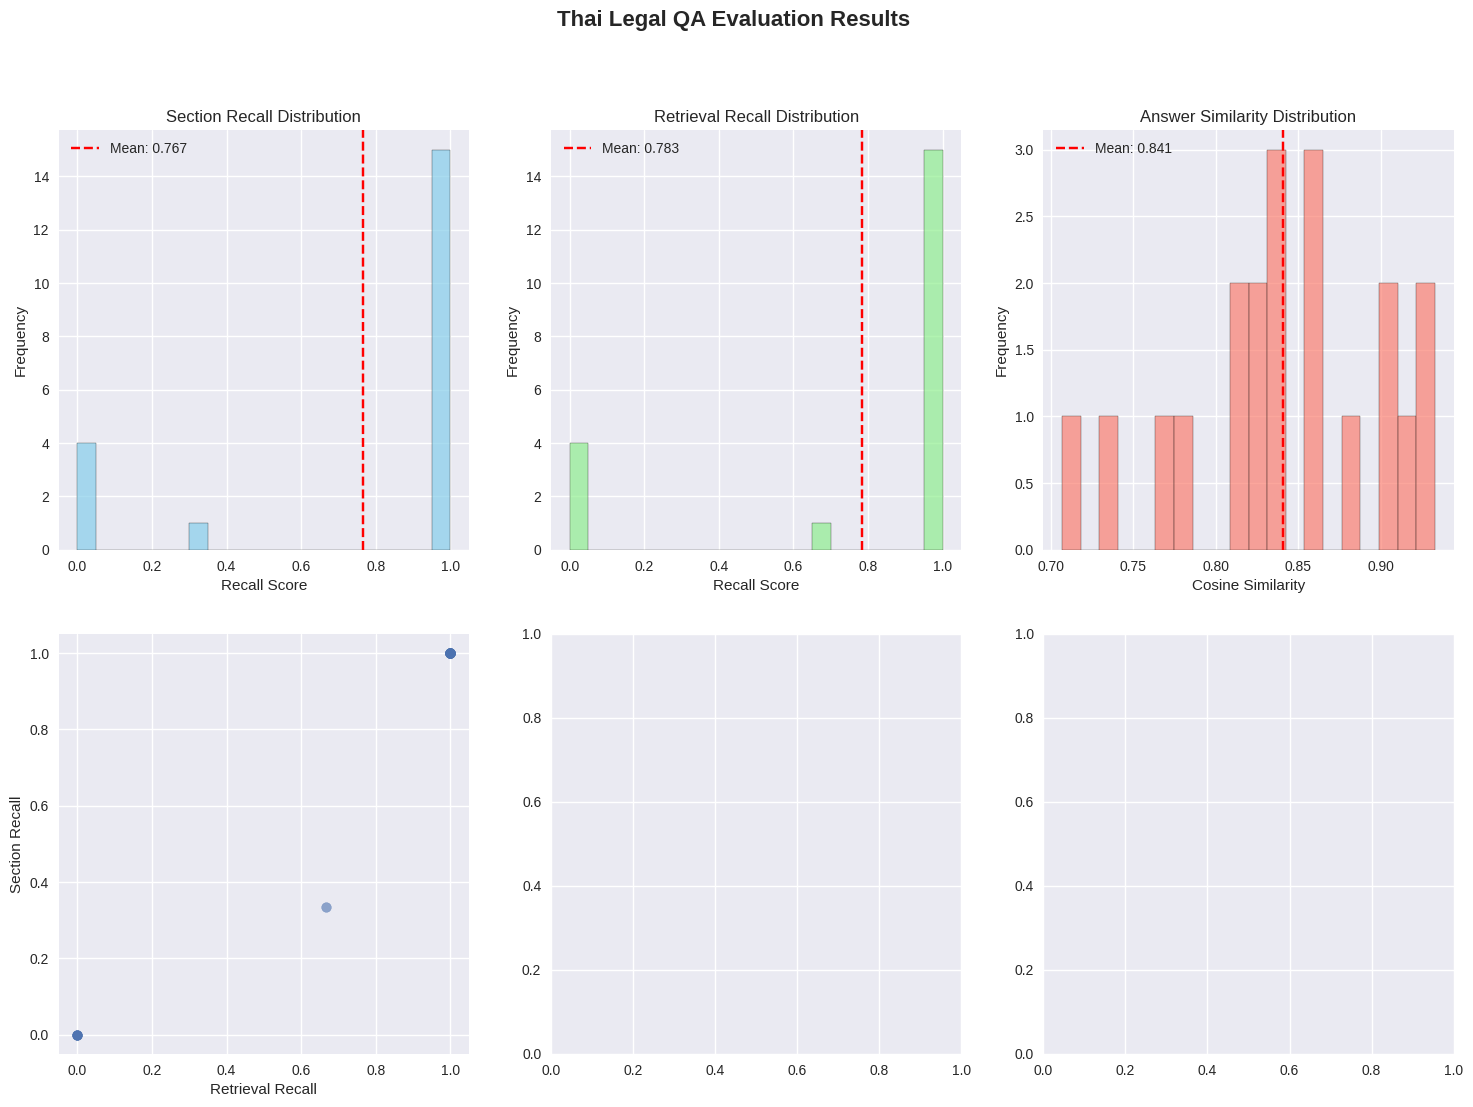

In [37]:
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Thai Legal QA Evaluation Results', fontsize=16, fontweight='bold')

# 1. Section Recall Distribution
axes[0, 0].hist(results_df['section_recall'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Section Recall Distribution')
axes[0, 0].set_xlabel('Recall Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(results_df['section_recall'].mean(), color='red', linestyle='--',
                   label=f'Mean: {results_df["section_recall"].mean():.3f}')
axes[0, 0].legend()

# 2. Retrieval Recall Distribution
axes[0, 1].hist(results_df['retrieval_recall'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Retrieval Recall Distribution')
axes[0, 1].set_xlabel('Recall Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(results_df['retrieval_recall'].mean(), color='red', linestyle='--',
                   label=f'Mean: {results_df["retrieval_recall"].mean():.3f}')
axes[0, 1].legend()

# 3. Answer Similarity Distribution
axes[0, 2].hist(results_df['answer_similarity'], bins=20, alpha=0.7, color='salmon', edgecolor='black')
axes[0, 2].set_title('Answer Similarity Distribution')
axes[0, 2].set_xlabel('Cosine Similarity')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(results_df['answer_similarity'].mean(), color='red', linestyle='--',
                   label=f'Mean: {results_df["answer_similarity"].mean():.3f}')
axes[0, 2].legend()

# 4. Section vs Retrieval Recall Scatter
axes[1, 0].scatter(results_df['retrieval_recall'], results_df['section_recall'], alpha=0.6)
axes[1, 0].set_xlabel('Retrieval Recall')
axes[1, 0].set_ylabel('Section Recall')
axes[1, 0].set_title

In [38]:
print("\n" + "="*80)
print("DETAILED PERFORMANCE ANALYSIS")
print("="*80)

# Questions with perfect section identification
perfect_section = results_df[results_df['section_recall'] == 1.0]
print(f"\nQuestions with perfect section recall: {len(perfect_section)}/{len(results_df)} ({len(perfect_section)/len(results_df)*100:.1f}%)")

# Questions with perfect retrieval
perfect_retrieval = results_df[results_df['retrieval_recall'] == 1.0]
print(f"Questions with perfect retrieval recall: {len(perfect_retrieval)}/{len(results_df)} ({len(perfect_retrieval)/len(results_df)*100:.1f}%)")

# High-quality answers (similarity > 0.8)
high_quality = results_df[results_df['answer_similarity'] > 0.8]
print(f"High-quality answers (similarity > 0.8): {len(high_quality)}/{len(results_df)} ({len(high_quality)/len(results_df)*100:.1f}%)")

# Correlation analysis
correlations = results_df[['section_recall', 'retrieval_recall', 'answer_similarity']].corr()
print(f"\nCorrelation Matrix:")
print(correlations.round(3))

# Failure analysis
zero_section_recall = results_df[results_df['section_recall'] == 0.0]
print(f"\nQuestions with zero section recall: {len(zero_section_recall)}")

if len(zero_section_recall) > 0:
    print("Sample failed cases:")
    for i, row in zero_section_recall.head(3).iterrows():
        print(f"\nQ: {row['question_text'][:100]}...")
        print(f"Gold sections: {row['gold_sections']}")
        print(f"Predicted sections: {row['predicted_sections']}")
        print(f"Retrieved sections: {row['retrieved_sections']}")


DETAILED PERFORMANCE ANALYSIS

Questions with perfect section recall: 15/20 (75.0%)
Questions with perfect retrieval recall: 15/20 (75.0%)
High-quality answers (similarity > 0.8): 16/20 (80.0%)

Correlation Matrix:
                   section_recall  retrieval_recall  answer_similarity
section_recall              1.000             0.984              0.348
retrieval_recall            0.984             1.000              0.420
answer_similarity           0.348             0.420              1.000

Questions with zero section recall: 4
Sample failed cases:

Q: ถ้าผู้ิยู่ในปกครองได้ยินยอมในการกระทำของผู้ปกครองจะทำให้ผู้ปกครองหลุดพ้นจากความรับผิดหรือเปล่า...
Gold sections: ['1598/5', '1598']
Predicted sections: ['1569/1', '1584', '1589', '1585', '1598/6', '1598/7', '1598/8']
Retrieved sections: ['1569/1', '1587', '1589', '1584', '1584/1', '1585', '1598/6', '1598/7', '1598/8']

Q: ถ้ามีการรับชำระหนี้ตามสัญญา นายหน้ามีอำนาจจะรับชำระหนี้ไว้หรือไม่...
Gold sections: ['849']
Predicted sections: 

In [39]:
results_df.to_csv('prompt_result.csv',index=False,encoding='utf-8-sig')